# Cahn-Hilliard problem with 2-D Neumann boundaries
The purpose of this notebook is to execute the Cahn-Hilliard problem in 2-D
as defined during the first CHiMaD Hackathon, problem 1b, using MMSP from
within the Jupyter notebook. This should replicate a terminal, with minor
text editing, but otherwise compiling and running using system calls.

## Warning: Executing this notebook as-is could take a week.
If you want to tinker, don't execute the last few sections (10<sup>6</sup>&mdash;2&#215;10<sup>7</sup> timesteps) until you're sure it's worthwhile.

In [3]:
# If parallel is an option, use it. Specify the desired number of cores here.
%env cores = 4

env: cores=4


### Write the ```generate``` and ```update``` functions
While the MMSP codebase is several thousand lines, the user need only define two
functions: ```generate()``` and ```update()```. This can often be accomplished in
a hundred lines or so. Once written, these templated functions are compiled with
a generic ```main()``` and the underlying grid and data classes to produce a working
whole, using the excellent GNU ```make``` utility.

Thanks to the ```%%writefile``` magic, executing the next cell will write the cell's
contents to ```cahnhilliard.cpp```, which is the file ```make``` expects to define
```generate()``` and ```update()```.

In [1]:
%%writefile cahnhilliard.cpp
// cahn-hilliard.hpp
// Example code for 2D Cahn-Hilliard model problem
// Questions/comments to trevor.keller@nist.gov (Trevor Keller)

#ifndef CAHNHILLIARD_UPDATE
#define CAHNHILLIARD_UPDATE
#include"MMSP.hpp"          // pulls in the MMSP back-end (grid, data classes, etc.)
#include<cmath>
#include"cahn-hilliard.hpp" // defines the grid dimension (2) and type (double)

// Hard-code some system parameters and numerical constants at global scope for convenience

const double deltaX = 1.0;
const double Ca = 0.05;
const double Cb = 0.95;
const double Cm = 0.5*(Ca + Cb);
const double A = 2.0;
const double B = A/((Ca-Cm)*(Ca-Cm));
const double D = 2.0/(Cb-Ca);
const double K = 2.0;
const double CFL = 0.25;
const double dt = std::pow(deltaX, 4)*CFL/(32.0*D*K);

double energydensity(const double& C)
{
    return -0.5*A*pow(C-Cm,2) + 0.25*B*pow(C-Cm,4) + 0.25*Ca*pow(C-Ca,4) + 0.25*Cb*pow(C-Cb,4);
}

double dfdc(const double& C)
{
    return -A*(C-Cm) + B*pow(C-Cm, 3) + Ca*pow(C-Ca, 3) + Cb*pow(C-Cb, 3);
}


namespace MMSP {

void generate(int dim, const char* filename)
{
    if (dim!=2) {
        std::cerr<<"ERROR: Initial condition is 2-D, only!"<<std::endl;
        std::exit(-1);
    }

    int rank=0;
    #ifdef MPI_VERSION
    rank = MPI::COMM_WORLD.Get_rank();
    #endif                                                                                                                                               

    const double q[2] = {0.1*std::sqrt(2.0), 0.1*std::sqrt(3.0)};                                                                                            
                                                                                                                                                             
    if (dim==2) {                                                                                                                                        
        MMSP::grid<2,double> grid(1,0,200,0,200);                                                                                                    
        for (int d=0; d<dim; d++){                                                                                                                   
            dx(grid,d) = deltaX;                                                                                                                 
            if (MMSP::x0(grid,d)==MMSP::g0(grid,d))                                                                                              
                MMSP::b0(grid,d) = Neumann; // enumerated in MMSP.utility.hpp                                                                    
            else if (MMSP::x1(grid,d)==MMSP::g1(grid,d))                                                                                         
                MMSP::b1(grid,d) = Neumann; // enumerated in MMSP.utility.hpp                                                                    
        }                                                                                                                                            

        for (int i=0; i<nodes(grid); i++) {                                                                                                          
            MMSP::vector<int> x = position(grid,i);                                                                                              
            grid(x) = 0.45 + 0.01 * std::cos(x[0]*dx(grid,0)*q[0] + x[1]*dx(grid,1)*q[1]);                                                       
        }                                                                                                                                            

        #ifdef MPI_VERSION                                                                                                                           
        MPI::COMM_WORLD.Barrier();                                                                                                                   
        #endif                                                                                                                                       
        output(grid,filename);                                                                                                                       
        if (rank==0)                                                                                                                                 
            std::cout<<"Timestep is "<<dt<<" (Co="<<CFL<<')'<<std::endl;                                                                         
    }                                                                                                                                                    
}                                                                                                                                                            
                                                                                                                                                             
template <int dim, typename T>                                                                                                                               
void update(MMSP::grid<dim,T>& grid, int steps)                                                                                                              
{                                                                                                                                                            
    int rank=0;                                                                                                                                          
    #ifdef MPI_VERSION                                                                                                                                   
    rank = MPI::COMM_WORLD.Get_rank();                                                                                                                   
    #endif                                                                                                                                               

    // Make sure the grid spacing is correct                                                                                                             
    for (int d=0; d<dim; d++) {                                                                                                                          
        dx(grid,d) = deltaX;                                                                                                                         
        if (MMSP::x0(grid,d)==MMSP::g0(grid,d))                                                                                                      
            MMSP::b0(grid,d) = Neumann; // enumerated in MMSP.utility.hpp                                                                            
        else if (MMSP::x1(grid,d)==MMSP::g1(grid,d))                                                                                                 
            MMSP::b1(grid,d) = Neumann; // enumerated in MMSP.utility.hpp                                                                            
    }                                                                                                                                                        
                                                                                                                                                             
    ghostswap(grid);                                                                                                                                     
                                                                                                                                                             
    // Let us be absolutely explicit about BCs here.                                                                                                          
    MMSP::grid<dim,T> update(grid);
    for (int d=0; d<dim; d++) {
        dx(update,d) = deltaX;
        if (MMSP::x0(update,d)==MMSP::g0(update,d))
            MMSP::b0(update,d) = Neumann; // enumerated in MMSP.utility.hpp
        else if (MMSP::x1(update,d)==MMSP::g1(update,d))
            MMSP::b1(update,d) = Neumann; // enumerated in MMSP.utility.hpp
    }

    MMSP::grid<dim,T> temp(grid);
    for (int d=0; d<dim; d++) {
        dx(temp,d) = deltaX;
        if (MMSP::x0(temp,d)==MMSP::g0(temp,d))
            MMSP::b0(temp,d) = Neumann; // enumerated in MMSP.utility.hpp
        else if (MMSP::x1(temp,d)==MMSP::g1(temp,d))
            MMSP::b1(temp,d) = Neumann; // enumerated in MMSP.utility.hpp
    }


    for (int step=0; step<steps; step++) {
        for (int i=0; i<nodes(grid); i++) {
            MMSP::vector<int> x = position(grid,i);
            double c = grid(x);
            temp(i) = dfdc(c) - K*laplacian(grid,x);
        }

        ghostswap(temp);

        double energy = 0.0;
        double mass = 0.0;
        for (int i=0; i<nodes(grid); i++) {
                MMSP::vector<int> x = position(grid,i);
                update(x) = grid(x)+dt*D*laplacian(temp,x);
                energy += dx(grid)*dy(grid)*energydensity(update(x));
                mass += dx(grid)*dy(grid)*update(x);
        }
        #ifdef MPI_VERSION
        MPI::COMM_WORLD.Barrier();
        double myEnergy = energy;
        double myMass = mass;
        MPI::COMM_WORLD.Allreduce(&myEnergy, &energy, 1, MPI_DOUBLE, MPI_SUM);
        MPI::COMM_WORLD.Allreduce(&myMass, &mass, 1, MPI_DOUBLE, MPI_SUM);
        #endif
        #ifndef DEBUG
        if (rank==0)
            std::cout<<energy<<'\t'<<mass<<'\n';
        #endif

        swap(grid,update);
        ghostswap(grid);
    }
    #ifndef DEBUG
    if (rank==0)
        std::cout<<std::flush;
    #endif
}

} // MMSP
#endif

#include"MMSP.main.hpp"


Overwriting cahnhilliard.cpp


### Compile for serial or parallel execution
Assuming you have exported the path to MMSP as ```$MMSP_PATH```, this should work.

In [2]:
# get rid of old executables
!make clean

# Serial is the default, so simply execute
!make

# Parallel is just as easy:
!make parallel

rm -f cahn-hilliard parallel ctcms debug fnbnd
g++ -O3 -Wall -I /users/tnk10/Downloads/mmsp/include cahn-hilliard.cpp -o cahn-hilliard -lz
mpic++ -O3 -Wall -I /users/tnk10/Downloads/mmsp/include -include mpi.h cahn-hilliard.cpp -o parallel -lz


### Take baby steps
Using the generic ```main()```, simulations are run in two stages:
* First using the ```--example 2``` flag, which triggers grid construction and initialization in 2D
* Next using the filename you wrote, the total runtime, and the number of steps between checkpoints

In [4]:
# This test run should take 5-10 minutes. It will produce no output. Be patient.

# Create a place for data to live, and delete stale runtime log file if it exists
!mkdir data
!rm -f energy.log

## Serial
## Initialize your 2D domain
#!./cahn-hilliard --example 2 data/test.0000.dat
#
## Take a thousand steps, saving the output (energy and composition) to energy.log
#!./cahn-hilliard data/test.0000.dat 1000 1000 > energy.log

# Parallel
# Initialize your 2D domain 
!mpirun -np $cores ./parallel --example 2 data/test.0000.dat

# Take a thousand steps, saving the output (energy and composition) to energy.log
!mpirun -np $cores ./parallel data/test.0000.dat 1000 1000 > energy.log

mkdir: cannot create directory ‘data’: File exists
Timestep is 0.00175781 (Co=0.25)


### Visualize the checkpoint result

Rescaling on [0,1].


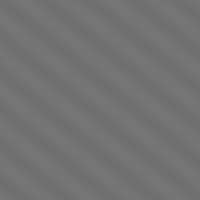

In [17]:
# Convert the binary data to a viewable PNG image. Specify --zoom to show higher contrast.
!mmsp2png data/test.1000.dat

# Show the result
from IPython.display import Image
Image('data/test.1000.png')

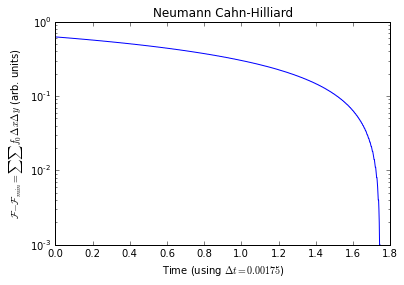

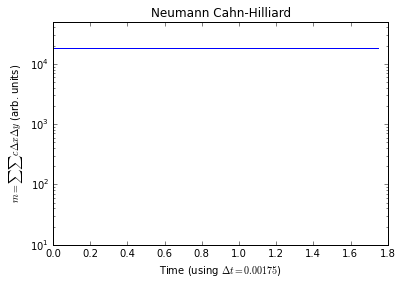

In [6]:
%matplotlib inline
# Plot energy and mass from energy.log. Let's make it a function, since it's handy to have around.
def plot_energy():
    import matplotlib.pylab as plt
    import numpy as np

    dt = 0.00175 # make sure this matches the value reported from generate()

    e,c = np.loadtxt('energy.log',usecols=(0, 1), unpack=True, skiprows=1, delimiter='\t')
    t = dt*np.arange(0,len(e))

    # Plot energy vs. time
    plt.semilogy(t, e-np.min(e))
    plt.xlabel(r'Time (using $\Delta t={0}$)'.format(dt))
    plt.ylabel(r'$\mathcal{F}-\mathcal{F}_{min}=\sum\sum f_0\Delta x\Delta y$ (arb. units)')
    plt.title("Neumann Cahn-Hilliard")
    plt.show()

    # Plot composition vs. time
    plt.semilogy(t, c)
    plt.xlabel(r'Time (using $\Delta t={0}$)'.format(dt))
    plt.ylabel(r'$m=\sum\sum c\Delta x\Delta y$ (arb. units)')
    plt.ylim([10, 5e4])
    plt.title("Neumann Cahn-Hilliard")
    plt.show()
plot_energy()

### Run in earnest
Those graphs look good to me: mass is conserved, and energy is falling. Let 'er rip!

In [7]:
# WARNING: This cell can take several hours to execute.

# Clear the log
!rm energy.log

## Serial
## Take a million steps, saving the output (energy and composition) to energy.log
#!./cahn-hilliard data/test.0000.dat 1000000 100000 > energy.log

# Parallel
# Take a million steps, saving the output (energy and composition) to energy.log
!mpirun -np $cores ./parallel data/test.0000.dat 1000000 100000 > energy.log

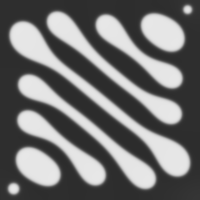

In [18]:
# Convert all the binaries to viewable PNG images
!for f in data/test.*.dat; do mmsp2png $f >/dev/null; done

# Show the last result
from IPython.display import Image
Image('data/test.1000000.png')

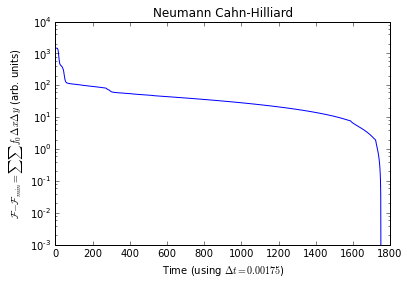

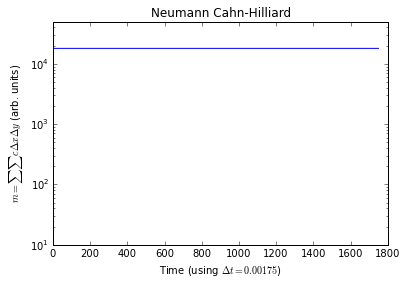

In [9]:
# Check that mass was conserved
plot_energy()

### Looks good...
... or at least not obviously wrong. Note that 10<sup>6</sup> timesteps took 11 hours with two cores, and the system is definitely not equilibrated (or steady-stated). Once more unto the breach...

In [10]:
# WARNING: This cell can take several days to execute!

## Serial
## Take nine million more steps, saving the output (energy and composition) to energy.log
#!./cahn-hilliard data/test.1000000.dat 10000000 100000 >> energy.log

# Parallel
# Take nine million more steps, saving the output (energy and composition) to energy.log
!mpirun -np $cores ./parallel data/test.1000000.dat 10000000 100000 >> energy.log

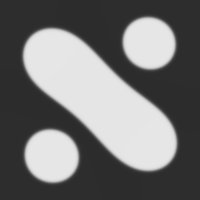

In [19]:
# Convert all the binaries to viewable PNG images
!for f in data/test.????????.dat; do mmsp2png $f >/dev/null; done

# Show the last result
from IPython.display import Image
Image('data/test.10000000.png')

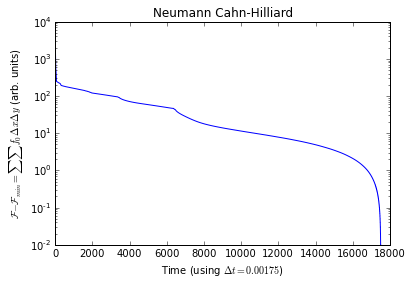

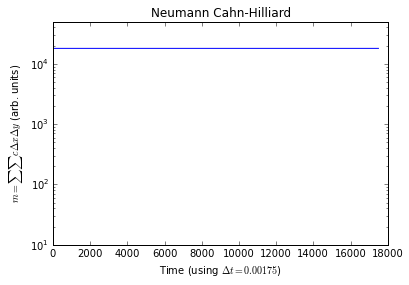

In [14]:
# Check that mass was conserved
plot_energy()

Still conserving mass, free energy is monotonically decreasing, and the system looks to be trending toward one circular domain of enriched phase. Let's see.

In [15]:
# WARNING: This cell can take several days to execute!

## Serial
## Take ten million more steps, saving the output (energy and composition) to energy.log
#!./cahn-hilliard data/test.10000000.dat 20000000 100000 >> energy.log

# Parallel
# Take ten million more steps, saving the output (energy and composition) to energy.log
!mpirun -np $cores ./parallel data/test.10000000.dat 20000000 100000 >> energy.log

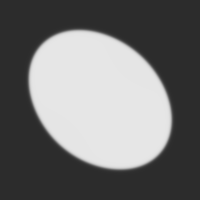

In [20]:
# Convert all the binaries to viewable PNG images
!for f in data/test.????????.dat; do mmsp2png $f >/dev/null; done

# Show the last result
from IPython.display import Image
Image('data/test.20000000.png')

## $\mathit{fin}$
The ellipsoid will eventually become a perfect circle. Beyond this point, the simulation is no longer interesting.